In [9]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sympy import *
%matplotlib notebook
from numba import jit, njit

x1 = symbols('x1')
u1 = symbols('u1')

In [10]:
@njit
def thomasAlgorithm(A,d): #Tridiagonal matrix algorithm . Или метод прогонки
    n = len(d)
    P = np.zeros(n - 1)
    Q = np.zeros(n - 1)
    x = np.zeros(n)
    P[0] = A[0][1] / -A[0][0]
    Q[0] = -d[0] / -A[0][0]
    for i in range(1, n - 1): # находим прогоночные коэффициенты
        a = A[i][i-1]
        b = A[i][i]
        c = A[i][i+1]
        
        P[i] = c/(-b-a*P[i - 1])
        Q[i] =(a*Q[i - 1]-d[i])/(-b-a*P[i - 1])
    x[-1] = (A[n - 1][n - 2]*Q[n - 2] - d[n - 1]) / (-A[n - 1][n - 1] - A[n - 1][n - 2]*P[n - 2])
    for i in range(n-2, -1, -1): # Находим неизвекстные
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [11]:
D = 0.5 #Коэффициент миграции
a = 2.0 # Рождаймость
K = 5.0 # количество ресурсов
smert = 1.# смертность

N = 100 #количество точек по оси OX
x0 = 0. # начало отрезка 
L = 100. # конец отрезка
h = (L - x0) / (N - 1) # шаг по OX

KT = 1000 #количество точек по времени
t0 = 0. # начальный момент времени
T = 100. # конечный момент времени
tau = (T - t0) / (KT - 1) # шаг по времени

sigma = tau*D/h**2 #sigma - число Куранта

A = np.zeros((N - 2, N - 2))
d = np.zeros((N - 2))

print(sigma)

0.04905405405405405


In [12]:
@njit
def solutionMatrixStart(): # заполнение матрицы решений краевыми условиями
    x = np.linspace(x0, L, N)
    u = np.zeros((N, KT))
    for i in range(0, KT):
        u[0][i] = 1
        u[-1][i] = 0
    for i in range(0, N):
        u[i][0] = 0
        u[i][-1] = 0
    return u, x

In [13]:
#@jit(nopython=True)
def createAndSolveMatrix(typeK): #заполняем трехдиагональную матрицу Ax=d
    u, x = solutionMatrixStart()
    #print(u)
    for i in range(1,KT): 
        A[0, 0] = - 2*sigma - (a*tau*u[1][i - 1])/typeK(i, u[1][i-1]) - smert*tau - 1
        A[0, 1] = sigma
        d[0] = (a*tau+1)*(-u[1][i - 1]) - sigma * u[0][i] 

        for j in range(1, N-3):
            A[j, j - 1] = sigma
            A[j, j] = - 2*sigma - (a*tau*u[j + 1][i - 1])/typeK(i, u[j][i - 1]) - smert*tau - 1
            A[j, j + 1] = sigma
            d[j] = (a*tau+1)*(-u[j + 1][i - 1])
    
        A[N - 3, N - 3] = - 2*sigma - (a*tau*u[N-2][i - 1])/typeK(i, u[N-2][i - 1]) - smert*tau - 1
        A[N - 3, N - 4] = sigma
        d[N - 3] = (a*tau+1)*(-u[N-2][i - 1]) - sigma *u[N - 1][i] 
        #print (A,d)
        u[1:N - 1, i] = thomasAlgorithm(A, d)
        #print(u)
    return u, x

$$F(u)=au^k_j\cdot(1-u^{k+1}_j/K)- \sigma u^{k+1}_j$$

In [14]:
def typeK(i, u1): return K

u, x = createAndSolveMatrix(typeK)

D = 0.5 a = 2.0 smert = 1.0 K0 = 5.0


<IPython.core.display.Javascript object>


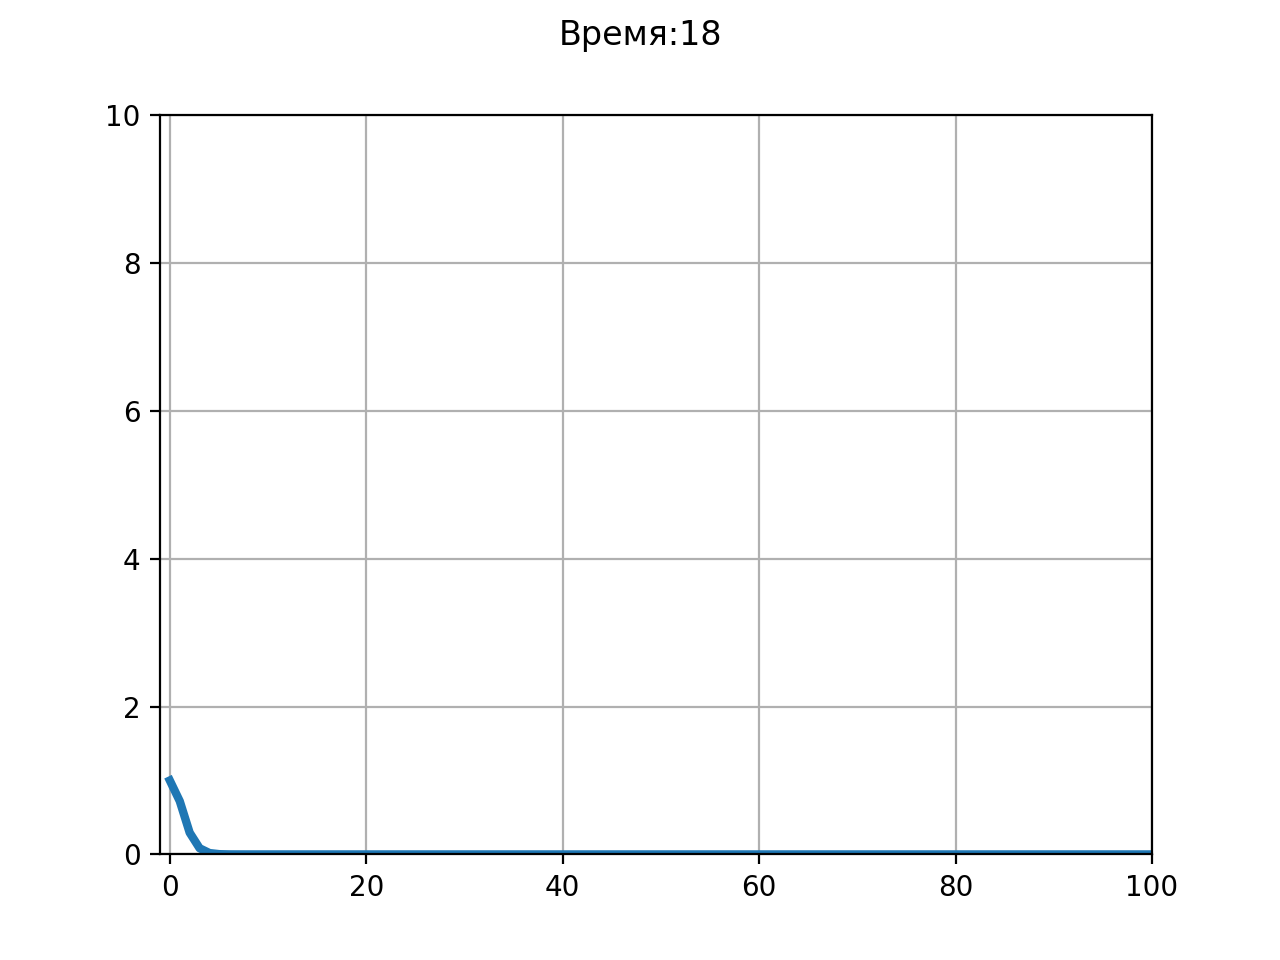

In [15]:
print("D = " + str(D) + ' a = ' + str(a) + " smert = " + str(smert) + " K0 = " + str(K) )
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 10) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

In [16]:
def Kt(t, u1=0): return 6000/t

u, x = createAndSolveMatrix(Kt)

<IPython.core.display.Javascript object>


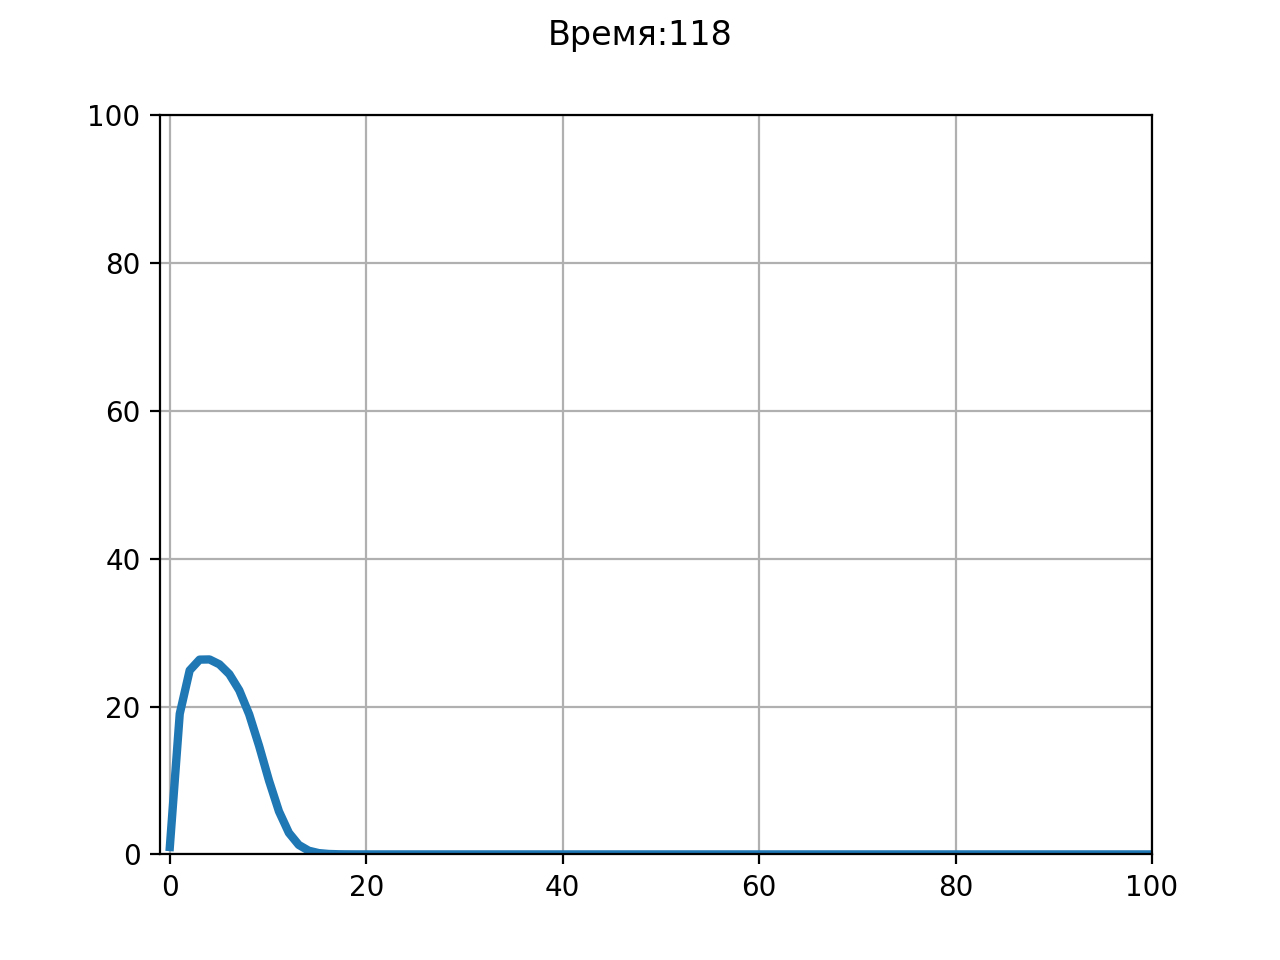

In [17]:
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 100) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()

In [18]:
K = 10
K1 = 1

def KTI(i, u1): return K + K1 * integrate(u1, (x1, x0, L))

u, x = createAndSolveMatrix(KTI)

D = 0.5 a = 2.0 smert = 1.0 K0 = 10 K1 = 1


<IPython.core.display.Javascript object>


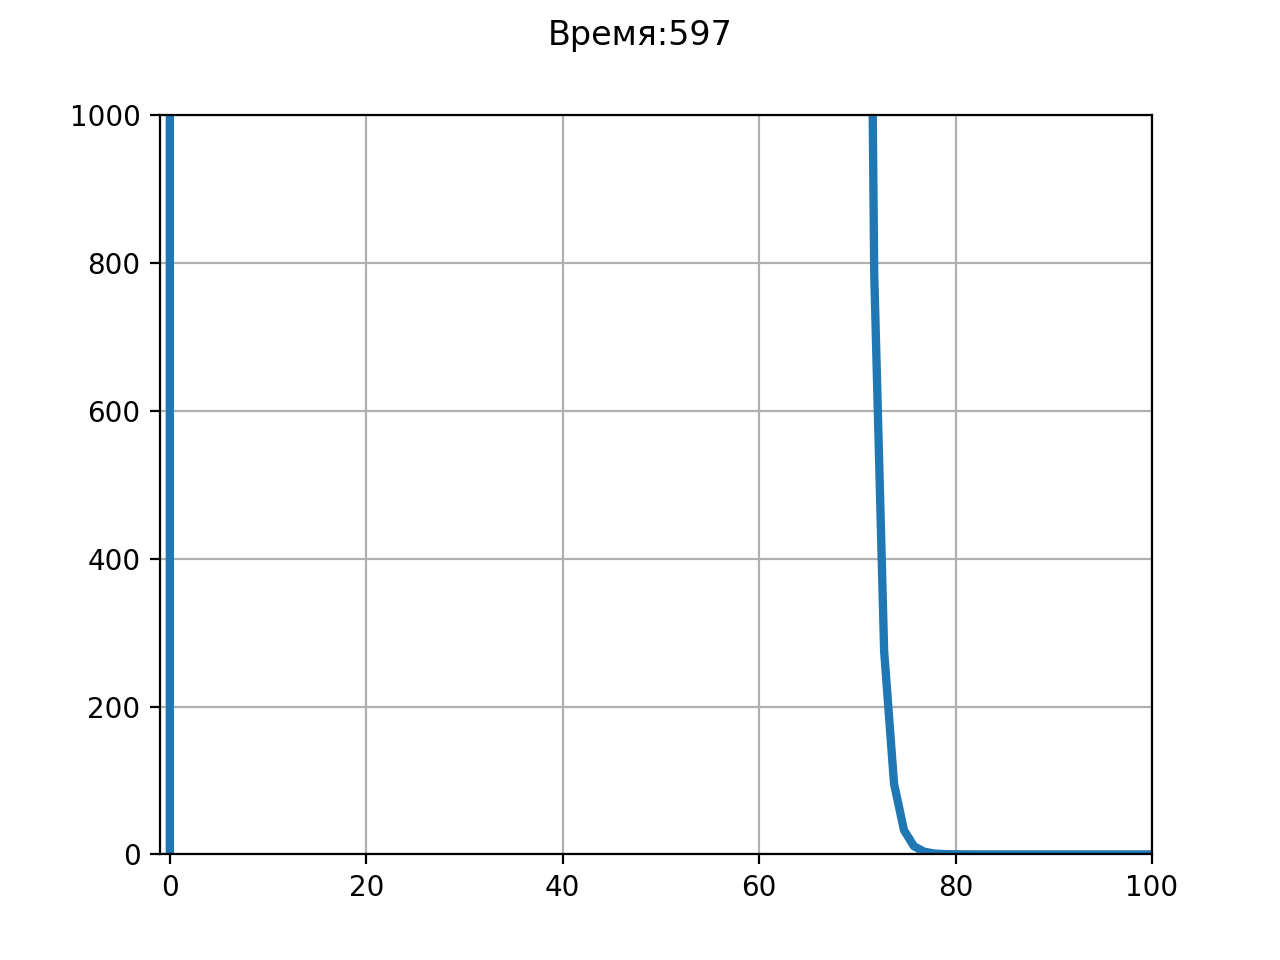

In [20]:
print("D = " + str(D) + ' a = ' + str(a) + " smert = " + str(smert) + " K0 = " + str(K) + " K1 = " + str(K1))
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 1000) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=50)
plt.grid(True)
plt.show()

In [28]:
K = 10
K1 = 1

def KTInt(u1):
    return K + K1 * Integrate(u1)

def Integrate(u1):
    return integrate(u1, (x1, x0, L))


u, x = solutionMatrixStart()
for i in range(1,KT): #заполняем трехдиагональную матрицу Ax=d
    A[0, 0] = -2*sigma - smert - 1
    A[0, 1] = smert
    d[0] = -u[1][i - 1] - tau*a*u[1][i - 1]*(1 - Integrate(u[1][i - 1])/KTInt(u[1][i - 1]))  - smert*u[0][i]  

    for j in range(1, N-3):
        A[j, j - 1] = smert
        A[j, j] = -2*sigma - smert - 1
        A[j, j + 1] = smert
        d[j] = -u[j + 1][i - 1] - tau*a*u[j + 1][i - 1]*(1 - Integrate(u[j + 1][i - 1])/KTInt(u[j + 1][i - 1]))
    
    A[N - 3, N - 3] = -2*sigma - smert - 1
    A[N - 3, N - 4] = smert
    d[N - 3] = -u[N-2][i - 1] - tau*a*u[N-2][i - 1]*(1 - Integrate(u[N-2][i - 1])/KTInt(u[N-2][i - 1]))  - smert*u[N-1][i]  
    #print (A,d)
    u[1:N - 1, i] = thomasAlgorithm(A, d)

D = 0.5 a = 2.0 smert = 1.0 K0 = 10 K1 = 1


<IPython.core.display.Javascript object>


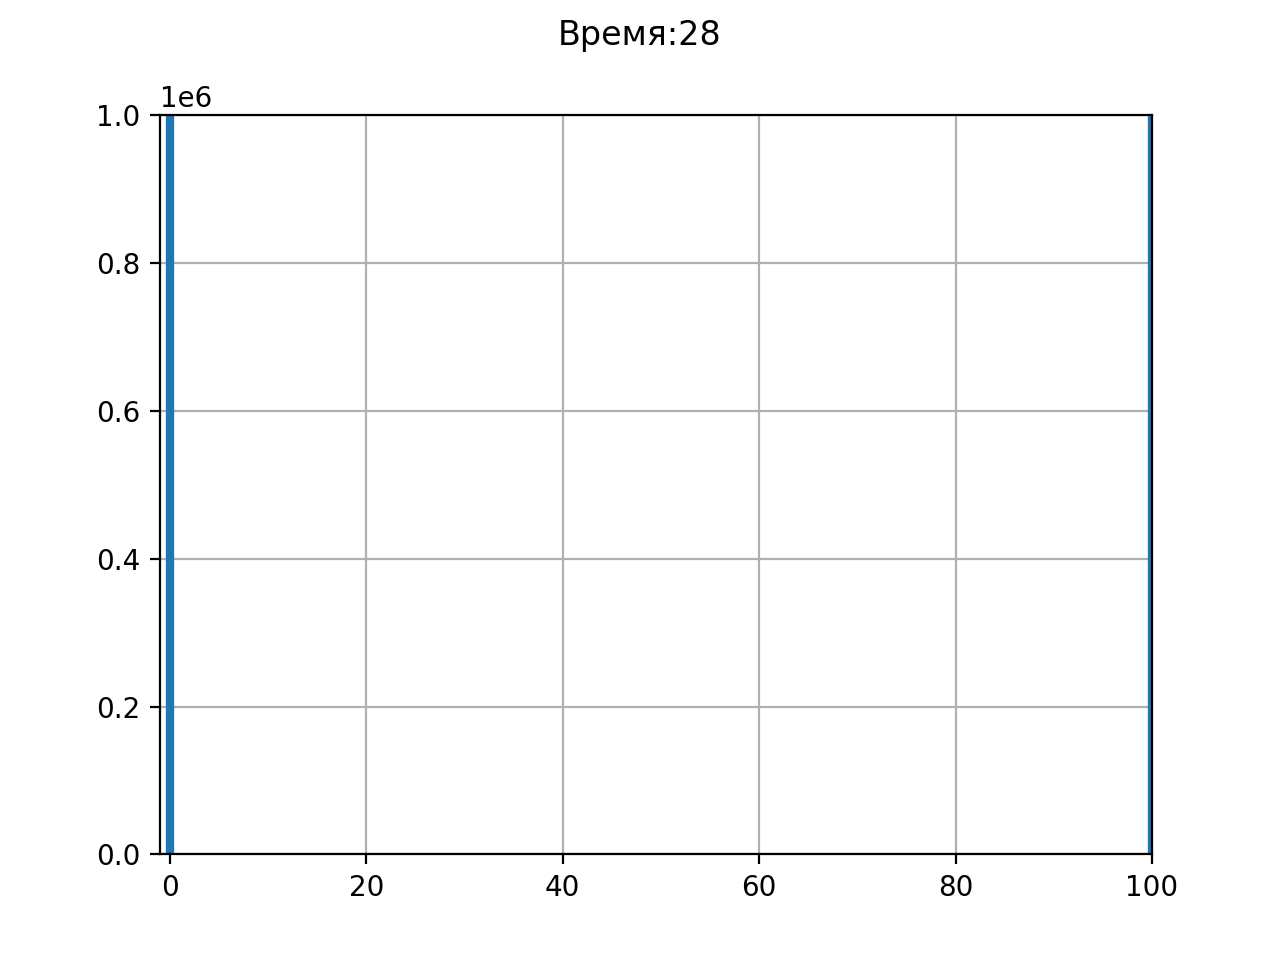

In [31]:
print("D = " + str(D) + ' a = ' + str(a) + " smert = " + str(smert) + " K0 = " + str(K) + " K1 = " + str(K1))
fig = plt.figure(facecolor='white')
ax = plt.axes(xlim=(-1, L), ylim=(0, 1000000) )
line, = ax.plot([ ], [ ], lw=3)
def redraw(i):
    line.set_data(x, u[:,i])
    string = 'Время:'+str(i)
    plt.suptitle(string)
anim = animation.FuncAnimation(fig,redraw,frames=KT,interval=100)
plt.grid(True)
plt.show()